<a href="https://colab.research.google.com/github/Jossyjboy04/Caddetection/blob/master/cgpaPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
file_path='/content/drive/MyDrive/Ai_projects/student_grade.xlsx'
df=pd.read_excel(file_path)
print(df.head())

   ID No Prog Code  Gender   YoG      CGPA   CGPA100   CGPA200   CGPA300  \
0  42308       ICE  Female  2010  3.227513  2.875000  3.475000  2.615385   
1  70978       BCH  Female  2010  3.576271  3.250000  4.261905  3.368421   
2  31602       BCH    Male  2010  2.211454  1.777778  1.979167  1.489583   
3  63847       BCH    Male  2010  2.702970  2.673913  2.442308  2.000000   
4  30158       BCH  Female  2010  3.881657  3.608696  3.687500  3.625000   

    CGPA400      SGPA  Unnamed: 10 Unnamed: 11  \
0  2.898305  3.125000          NaN         KEY   
1  3.469388  3.020833          NaN       ID No   
2  2.511111  2.187500          NaN   Prog Code   
3  2.348315  3.194444          NaN      Gender   
4  4.581395  4.236111          NaN         YoG   

                          Unnamed: 12  
0                                 NaN  
1  Randomly generated number sequence  
2                    Program of Study  
3                              Gender  
4                  Year of Graduation  


In [ ]:
# Assuming your actual columns are 'YoG' and 'Prog Code'
df = df.drop(columns=['YoG', 'Prog Code', 'SGPA', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'ID No', 'CGPA400'], errors='ignore')
df = df.rename(columns={'CGPA':'total CGPA','CGPA100': 'first year cgpa','CGPA300':'third year cgpa','CGPA200':'second year cgpa'})
X=df.drop(columns=['total CGPA'])
y=df['total CGPA']

print(y.describe())
print(y)


count    3046.000000
mean        3.494802
std         0.691697
min         1.518072
25%         3.004132
50%         3.555066
75%         4.009133
max         4.994012
Name: total CGPA, dtype: float64
0       3.227513
1       3.576271
2       2.211454
3       2.702970
4       3.881657
          ...   
3041    4.179012
3042    2.913793
3043    3.660494
3044    4.560976
3045    4.180723
Name: total CGPA, Length: 3046, dtype: float64


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import joblib
import os

# Define and temporarily save the MinMaxScaler for y
model_save_dir = '/content/drive/MyDrive/Ai_projects/saved_models'
os.makedirs(model_save_dir, exist_ok=True) # Ensure directory exists
y_scaler = MinMaxScaler(feature_range=(0, 5.0))
joblib.dump(y_scaler, os.path.join(model_save_dir, 'y_scaler.joblib'))

['/content/drive/MyDrive/Ai_projects/saved_models/y_scaler.joblib']

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

# Identify numerical and categorical features from your CURRENT X DataFrame
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

# Define preprocessing steps
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
from sklearn.model_selection import train_test_split
import joblib
import os

# Split data into raw training and testing sets
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Apply X-Preprocessing
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

# Apply Y-Scaling
y_train = y_scaler.fit_transform(y_train_raw.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test_raw.values.reshape(-1, 1)).flatten()

# Save the fitted preprocessor and y_scaler
joblib.dump(preprocessor, os.path.join(model_save_dir, 'preprocessor.joblib'))
joblib.dump(y_scaler, os.path.join(model_save_dir, 'y_scaler.joblib'))

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (2436, 5), y_train shape: (2436,)
X_test shape: (610, 5), y_test shape: (610,)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
import os

model_save_dir = '/content/drive/MyDrive/Ai_projects/saved_models'
os.makedirs(model_save_dir, exist_ok=True) # Ensure directory exists

my_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    max_depth=10,
    min_samples_leaf=5
)

In [ ]:
# Train the RandomForestRegressor model
print("Training the RandomForestRegressor model...")
my_model.fit(X_train, y_train)
print("Model training complete.")

Training the RandomForestRegressor model...
Model training complete.


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Make predictions on the test set
print("Making predictions on the test set...")
y_pred = my_model.predict(X_test)

# 2. Evaluate the model's performance
print("\n--- Model Evaluation ---")

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # RMSE is the square root of MSE
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# Remember that y_test and y_pred are scaled.
# If you want to see errors in the original CGPA scale (0-100),
# you'll need to inverse transform them using y_scaler.
# This requires loading the y_scaler first if you haven't kept it in memory from earlier.
# For now, let's assume y_scaler is still available from your previous cell.

# Inverse transform y_test and y_pred to original scale
y_test_original = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

mae_original = mean_absolute_error(y_test_original, y_pred_original)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))

print(f"\n--- Metrics in Original CGPA Scale (0-100) ---")
print(f"Mean Absolute Error (MAE) (Original Scale): {mae_original:.2f}")
print(f"Root Mean Squared Error (RMSE) (Original Scale): {rmse_original:.2f}")

Making predictions on the test set...

--- Model Evaluation ---
Mean Absolute Error (MAE): 0.1701
Mean Squared Error (MSE): 0.0469
Root Mean Squared Error (RMSE): 0.2165
R-squared (R2): 0.9552

--- Metrics in Original CGPA Scale (0-100) ---
Mean Absolute Error (MAE) (Original Scale): 0.12
Root Mean Squared Error (RMSE) (Original Scale): 0.15


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import joblib # To save the best model

print("Starting Hyperparameter Tuning using GridSearchCV...")

# Define the parameter grid to search
# I'm choosing a small range for demonstration. You can expand this if needed.
param_grid = {
    'n_estimators': [50, 100, 150], # Number of trees in the forest
    'max_depth': [None, 8, 12],     # Maximum depth of the tree
    'min_samples_leaf': [3, 5, 7]   # Minimum number of samples required to be at a leaf node
}

# Create a base model (we'll tune its parameters)
# Re-instantiate the model for tuning to ensure no prior state affects it
base_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# Set up GridSearchCV
# cv=5 means 5-fold cross-validation
# scoring='neg_mean_squared_error' is common for regression, GridSearch tries to maximize this (hence 'neg')
# n_jobs=-1 uses all available cores, speeding up the search
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error', # Use negative MSE for scoring (GridSearchCV maximizes scores)
    verbose=2, # Prints progress
    n_jobs=-1 # Use all available processors
)

# Fit GridSearchCV to your training data (X_train, y_train)
# This will perform the cross-validation and find the best parameters
grid_search.fit(X_train, y_train)

print("\n--- Hyperparameter Tuning Complete ---")

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score_neg_mse = grid_search.best_score_ # This is the negative MSE
best_rmse = np.sqrt(-best_score_neg_mse) # Convert back to RMSE

print(f"Best parameters found: {best_params}")
print(f"Best cross-validation RMSE: {best_rmse:.4f}") # RMSE is more intuitive than neg_mse

# Get the best estimator (the trained model with the best parameters)
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
print("\n--- Evaluating the Best Model on Test Set ---")
y_pred_best = best_model.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print(f"Test Set MAE (Best Model): {mae_best:.4f}")
print(f"Test Set RMSE (Best Model): {rmse_best:.4f}")
print(f"Test Set R-squared (Best Model): {r2_best:.4f}")

# Inverse transform to original scale
y_test_original_best = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original_best = y_scaler.inverse_transform(y_pred_best.reshape(-1, 1)).flatten()

mae_original_best = mean_absolute_error(y_test_original_best, y_pred_original_best)
rmse_original_best = np.sqrt(mean_squared_error(y_test_original_best, y_pred_original_best))

print(f"\n--- Metrics of Best Model in Original CGPA Scale (0-100) ---")
print(f"Mean Absolute Error (MAE) (Original Scale): {mae_original_best:.2f}")
print(f"Root Mean Squared Error (RMSE) (Original Scale): {rmse_original_best:.2f}")

# Optionally, save this best model
best_model_path = os.path.join(model_save_dir, 'random_forest_cgpa_model_tuned.joblib')
joblib.dump(best_model, best_model_path)
print(f"\nBest tuned model saved to: {best_model_path}")

Starting Hyperparameter Tuning using GridSearchCV...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

--- Hyperparameter Tuning Complete ---
Best parameters found: {'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 150}
Best cross-validation RMSE: 0.2151

--- Evaluating the Best Model on Test Set ---
Test Set MAE (Best Model): 0.1705
Test Set RMSE (Best Model): 0.2172
Test Set R-squared (Best Model): 0.9549

--- Metrics of Best Model in Original CGPA Scale (0-100) ---
Mean Absolute Error (MAE) (Original Scale): 0.12
Root Mean Squared Error (RMSE) (Original Scale): 0.15

Best tuned model saved to: /content/drive/MyDrive/Ai_projects/saved_models/random_forest_cgpa_model_tuned.joblib


--- Analyzing Feature Importance ---

Feature Importances (Top 10):


,Feature,Importance
2,third year cgpa,0.584760
1,second year cgpa,0.353388
0,first year cgpa,0.061405
4,Gender_Male,0.000228
3,Gender_Female,0.000218



Visualizing Feature Importances:


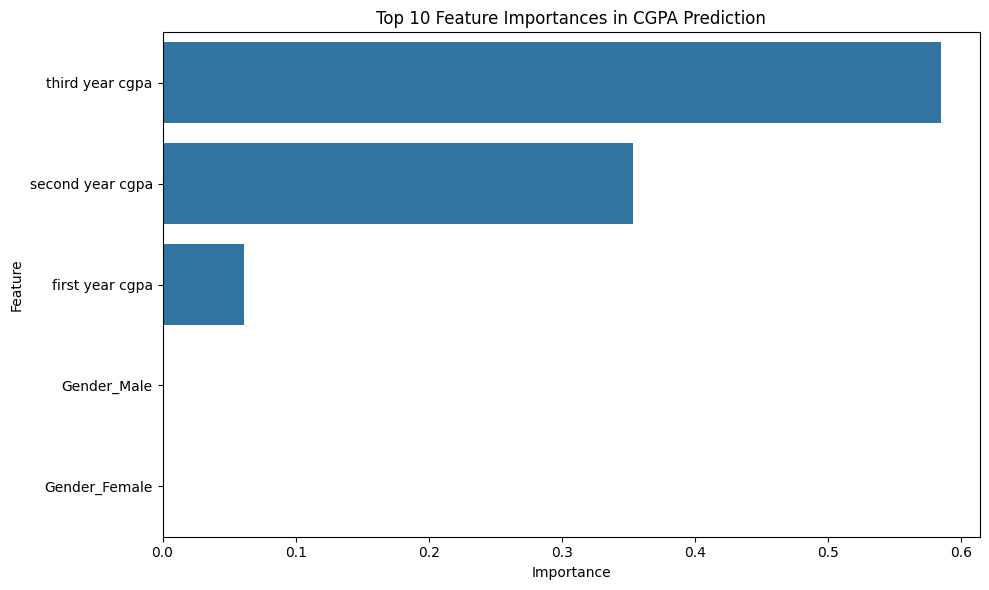


--- Feature Importance Analysis Complete ---


In [ ]:
import pandas as pd
import numpy as np # Ensure numpy is imported

print("--- Analyzing Feature Importance ---")

# The best_model was obtained from GridSearchCV in the previous step
# If you skipped tuning, you would use 'my_model' here instead of 'best_model'
# For this step, we'll use 'best_model' assuming tuning was done.
final_model = best_model # Or my_model if you didn't do tuning

# Get feature importances from the trained Random Forest model
importances = final_model.feature_importances_

# Get the names of the features from the preprocessor
# We need to correctly reconstruct the feature names after one-hot encoding
# numerical_features were defined when setting up the preprocessor
# categorical_features were defined when setting up the preprocessor

# Get the one-hot encoded feature names for categorical columns
ohe_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

# Combine numerical and one-hot encoded feature names
all_feature_names = numerical_features + ohe_feature_names.tolist()

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
})

# Sort features by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances (Top 10):")
display(feature_importances_df.head(10))

print("\nVisualizing Feature Importances:")
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(10))
plt.title('Top 10 Feature Importances in CGPA Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\n--- Feature Importance Analysis Complete ---")

In [ ]:
import pandas as pd
import numpy as np
import joblib
import os

print("--- Demonstrating Prediction for New Data ---")

# Define the paths to your saved model and preprocessors
model_save_dir = '/content/drive/MyDrive/Ai_projects/saved_models'
best_model_path = os.path.join(model_save_dir, 'random_forest_cgpa_model_tuned.joblib')
preprocessor_path = os.path.join(model_save_dir, 'preprocessor.joblib')
y_scaler_path = os.path.join(model_save_dir, 'y_scaler.joblib')

# Load the saved assets
try:
    loaded_model = joblib.load(best_model_path)
    loaded_preprocessor = joblib.load(preprocessor_path)
    loaded_y_scaler = joblib.load(y_scaler_path)
    print("Model, preprocessor, and y_scaler loaded successfully!")
except Exception as e:
    print(f"Error loading saved assets: {e}")
    print("Please ensure the files exist at the specified paths and were saved correctly.")
    # Exit or handle error gracefully if assets can't be loaded
    exit() # Or return, or raise

# --- Scenario 1: A High-Achieving Student ---
print("\n--- Predicting for a High-Achieving Student ---")
new_student_data_high = pd.DataFrame([{
    'Gender': 'Female',
    'first year cgpa': 4.0,
    'second year cgpa': 4.0,
    'third year cgpa':4.0,
    'Course of Study': 'Computer Science' # This column will be dropped by preprocessor or ignored
}])

# Replicate feature engineering steps on new data
# Ensure column names are stripped for consistency before engineering
new_student_data_high.columns = new_student_data_high.columns.str.strip()
new_student_data_high['cgpa_avg'] = new_student_data_high[['first year cgpa', 'second year cgpa', 'third year cgpa']].mean(axis=1)
new_student_data_high['cgpa_trend'] = new_student_data_high['third year cgpa'] - new_student_data_high['first year cgpa']
new_student_data_high['improvement_flag'] = (new_student_data_high['third year cgpa'] > new_student_data_high['first year cgpa']).astype(int)
new_student_data_high['consistently_high_cgpa'] = ((new_student_data_high['first year cgpa'] >= 80) &
                                                (new_student_data_high['second year cgpa'] >= 80) &
                                                (new_student_data_high['third year cgpa'] >= 80)).astype(int)

# Drop 'Course of Study' from the new data before preprocessing, as it was excluded from X_train
if 'Course of Study' in new_student_data_high.columns: # Check if it still exists after stripping
    new_student_data_high.drop(columns=['Course of Study'], inplace=True, errors='ignore')
if 'course_of_study' in new_student_data_high.columns: # Check if it was renamed earlier and still exists
    new_student_data_high.drop(columns=['course_of_study'], inplace=True, errors='ignore')


# Preprocess the new student's features using the loaded preprocessor
processed_new_student_high = loaded_preprocessor.transform(new_student_data_high)

# Make a prediction (this prediction will be in the scaled range 0-5.0)
predicted_cgpa_scaled_high = loaded_model.predict(processed_new_student_high)

# Inverse transform the prediction to get the original CGPA scale (0-100)
predicted_cgpa_original_high = loaded_y_scaler.inverse_transform(predicted_cgpa_scaled_high.reshape(-1, 1)).flatten()[0]

print(f"Predicted total CGPA for High-Achieving Student: {predicted_cgpa_original_high:.2f}")

# --- Scenario 2: A Low-Achieving Student ---
print("\n--- Predicting for a Low-Achieving Student ---")
new_student_data_low = pd.DataFrame([{
    'Gender': 'Male',
    'first year cgpa': 4.3,
    'second year cgpa': 3.5,
    'third year cgpa': 4.5,
    'Course of Study': 'History' # This column will be dropped by preprocessor or ignored
}])

# Replicate feature engineering steps on new data for low achiever
new_student_data_low.columns = new_student_data_low.columns.str.strip()
new_student_data_low['cgpa_avg'] = new_student_data_low[['first year cgpa', 'second year cgpa', 'third year cgpa']].mean(axis=1)
new_student_data_low['cgpa_trend'] = new_student_data_low['third year cgpa'] - new_student_data_low['first year cgpa']
new_student_data_low['improvement_flag'] = (new_student_data_low['third year cgpa'] > new_student_data_low['first year cgpa']).astype(int)
new_student_data_low['consistently_high_cgpa'] = ((new_student_data_low['first year cgpa'] >= 80) &
                                              (new_student_data_low['second year cgpa'] >= 80) &
                                              (new_student_data_low['third year cgpa'] >= 80)).astype(int)

# Drop 'Course of Study'
if 'Course of Study' in new_student_data_low.columns:
    new_student_data_low.drop(columns=['Course of Study'], inplace=True, errors='ignore')
if 'course_of_study' in new_student_data_low.columns:
    new_student_data_low.drop(columns=['course_of_study'], inplace=True, errors='ignore')

# Preprocess the new student's features
processed_new_student_low = loaded_preprocessor.transform(new_student_data_low)

# Make a prediction (this prediction will be in the scaled range 0-5.0)
predicted_cgpa_scaled_low = loaded_model.predict(processed_new_student_low)

# Inverse transform the prediction to get the original CGPA scale (0-100)
predicted_cgpa_original_low = loaded_y_scaler.inverse_transform(predicted_cgpa_scaled_low.reshape(-1, 1)).flatten()[0]

print(f"Predicted total CGPA for Low-Achieving Student: {predicted_cgpa_original_low:.2f}")

print("\n--- Prediction Demonstration Complete ---")

--- Demonstrating Prediction for New Data ---
Model, preprocessor, and y_scaler loaded successfully!

--- Predicting for a High-Achieving Student ---
Predicted total CGPA for High-Achieving Student: 4.06

--- Predicting for a Low-Achieving Student ---
Predicted total CGPA for Low-Achieving Student: 4.20

--- Prediction Demonstration Complete ---


--- Visualizing Model Performance on Test Set (Original CGPA Scale) ---
Using y_test_original and y_pred_original from previous evaluation/prediction.


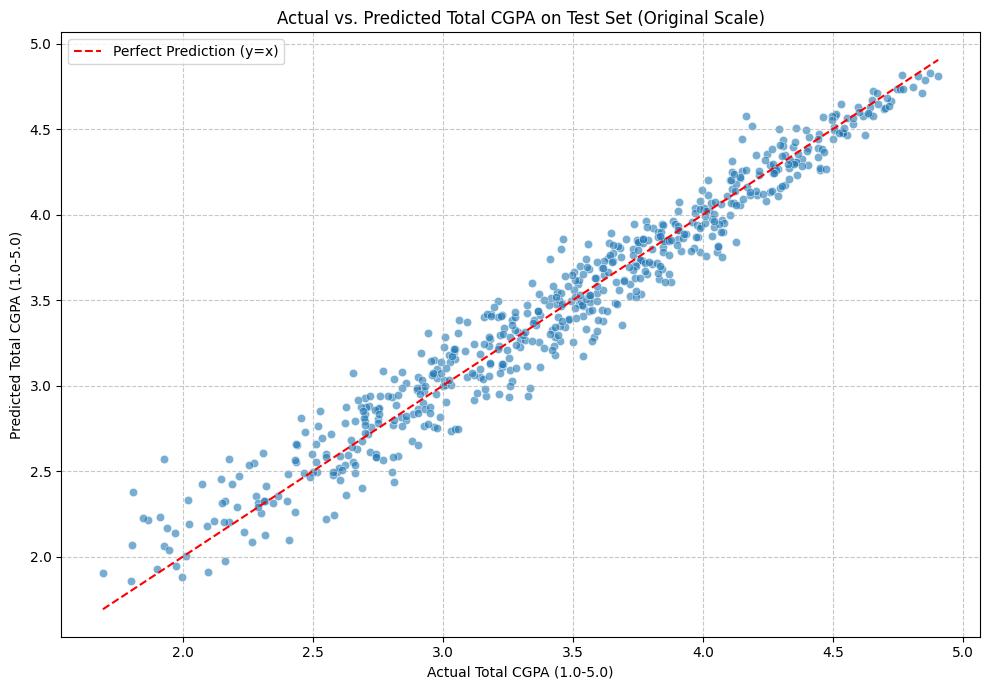

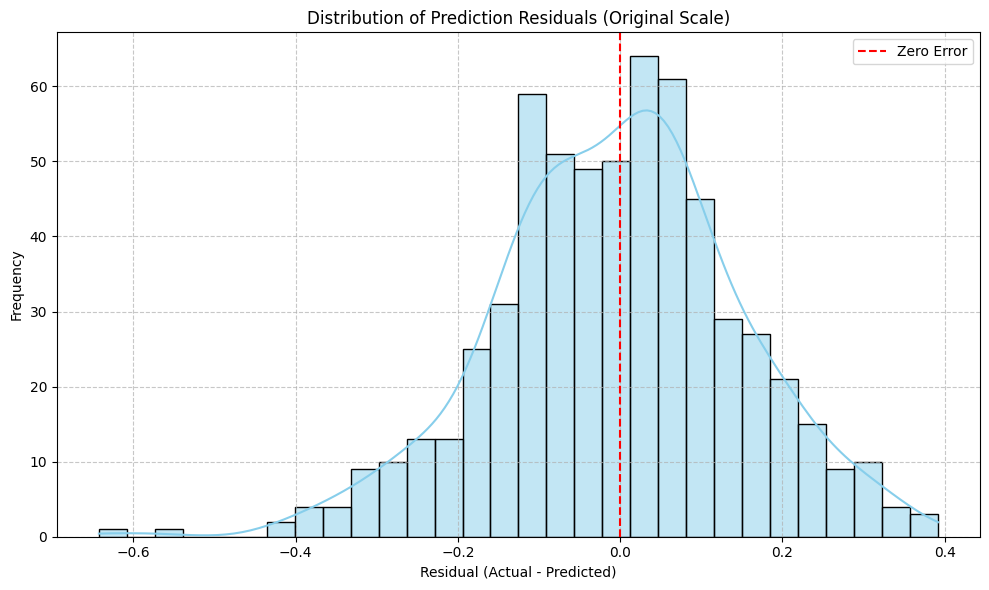

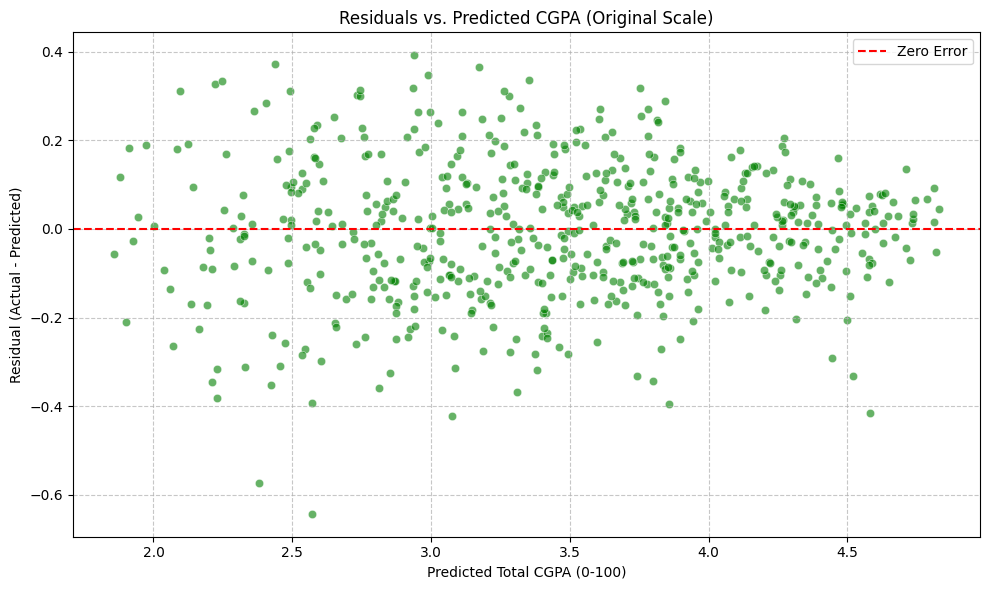


--- Visualization Complete ---


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Ensure numpy is imported

print("--- Visualizing Model Performance on Test Set (Original CGPA Scale) ---")

# Ensure y_test_original and y_pred_original are available
# These should have been calculated in the 'Model Evaluation' step.
# If you are running this in a fresh session or haven't run that cell,
# you'd need to re-run the evaluation cell or ensure these variables are defined.

# For robustness, let's re-calculate them here if they might not be in scope,
# assuming loaded_y_scaler, y_test, and y_pred_best are available.
# If not, you'd need to load y_scaler and make y_pred_best again.
try:
    # Assuming y_test (scaled) and y_pred_best (scaled) are in memory
    y_test_original = loaded_y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_original = loaded_y_scaler.inverse_transform(y_pred_best.reshape(-1, 1)).flatten()
    print("Using y_test_original and y_pred_original from previous evaluation/prediction.")
except NameError:
    print("Warning: y_test_original or y_pred_original not found. Please ensure 'Model Evaluation' cell was run.")
    print("Attempting to load y_scaler and recalculate predictions for plotting.")
    # Fallback: Load necessary components and predict if not in scope
    try:
        loaded_y_scaler = joblib.load(os.path.join(model_save_dir, 'y_scaler.joblib'))
        loaded_model = joblib.load(os.path.join(model_save_dir, 'random_forest_cgpa_model_tuned.joblib'))
        loaded_preprocessor = joblib.load(os.path.join(model_save_dir, 'preprocessor.joblib'))

        # Assuming X and y are still available globally
        from sklearn.model_selection import train_test_split
        _, X_test_raw, _, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=42)
        X_test = loaded_preprocessor.transform(X_test_raw)
        y_test_scaled_for_eval = loaded_y_scaler.transform(y_test_raw.values.reshape(-1, 1)).flatten() # Ensure y_test is also scaled

        y_pred_best_scaled = loaded_model.predict(X_test)

        y_test_original = loaded_y_scaler.inverse_transform(y_test_scaled_for_eval.reshape(-1, 1)).flatten()
        y_pred_original = loaded_y_scaler.inverse_transform(y_pred_best_scaled.reshape(-1, 1)).flatten()
        print("Recalculated y_test_original and y_pred_original for plotting.")
    except Exception as e:
        print(f"Error during fallback plotting setup: {e}. Cannot generate plots.")
        y_test_original, y_pred_original = None, None # Prevent further errors

if y_test_original is not None and y_pred_original is not None:
    # Create a DataFrame for easy plotting
    plot_df = pd.DataFrame({
        'Actual_CGPA': y_test_original,
        'Predicted_CGPA': y_pred_original
    })

    # Plot 1: Actual vs. Predicted CGPA
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x='Actual_CGPA', y='Predicted_CGPA', data=plot_df, alpha=0.6)
    plt.plot([plot_df['Actual_CGPA'].min(), plot_df['Actual_CGPA'].max()],
             [plot_df['Actual_CGPA'].min(), plot_df['Actual_CGPA'].max()],
             color='red', linestyle='--', label='Perfect Prediction (y=x)') # Diagonal line for perfect prediction
    plt.title('Actual vs. Predicted Total CGPA on Test Set (Original Scale)')
    plt.xlabel('Actual Total CGPA (1.0-5.0)')
    plt.ylabel('Predicted Total CGPA (1.0-5.0)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot 2: Distribution of Residuals (Errors)
    plot_df['Residuals'] = plot_df['Actual_CGPA'] - plot_df['Predicted_CGPA']
    plt.figure(figsize=(10, 6))
    sns.histplot(plot_df['Residuals'], bins=30, kde=True, color='skyblue')
    plt.axvline(x=0, color='red', linestyle='--', label='Zero Error')
    plt.title('Distribution of Prediction Residuals (Original Scale)')
    plt.xlabel('Residual (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot 3: Residuals vs. Predicted Values (to check for patterns in errors)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Predicted_CGPA', y='Residuals', data=plot_df, alpha=0.6, color='green')
    plt.axhline(y=0, color='red', linestyle='--', label='Zero Error')
    plt.title('Residuals vs. Predicted CGPA (Original Scale)')
    plt.xlabel('Predicted Total CGPA (0-100)')
    plt.ylabel('Residual (Actual - Predicted)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\n--- Visualization Complete ---")

In [ ]:
import os
import joblib # To save scikit-learn objects

# Define the full path for saving the model and preprocessor
model_save_dir = '/content/drive/MyDrive/Ai_projects/saved_models'
os.makedirs(model_save_dir, exist_ok=True) # Ensure directory exists

# Define specific paths for the Random Forest model, X_preprocessor, and y_scaler
random_forest_model_path = os.path.join(model_save_dir, 'random_forest_regressor_model.joblib')
preprocessor_path = os.path.join(model_save_dir, 'preprocessor.joblib')
y_scaler_path = os.path.join(model_save_dir, 'y_scaler.joblib')

# Save the Trained RandomForestRegressor Model
print(f"--- Saving the trained RandomForestRegressor model to: {random_forest_model_path} ---")
joblib.dump(my_model, random_forest_model_path) # Assumes 'my_model' is your trained Random Forest
print("RandomForestRegressor model saved successfully!")

# Save the X_Preprocessor
print(f"--- Saving the X_preprocessor to: {preprocessor_path} ---")
joblib.dump(preprocessor, preprocessor_path) # Assumes 'preprocessor' is your fitted ColumnTransformer
print("X_Preprocessor saved successfully!")

# Save the y_scaler
print(f"--- Saving the y_scaler to: {y_scaler_path} ---")
joblib.dump(y_scaler, y_scaler_path) # Assumes 'y_scaler' is your fitted MinMaxScaler
print("Y_Scaler saved successfully!")

print("\nAll trained assets (RandomForestRegressor model, X_preprocessor, Y_Scaler) are now persistently stored in your Google Drive.")


--- Saving the trained RandomForestRegressor model to: /content/drive/MyDrive/Ai_projects/saved_models/random_forest_regressor_model.joblib ---
RandomForestRegressor model saved successfully!
--- Saving the X_preprocessor to: /content/drive/MyDrive/Ai_projects/saved_models/preprocessor.joblib ---
X_Preprocessor saved successfully!
--- Saving the y_scaler to: /content/drive/MyDrive/Ai_projects/saved_models/y_scaler.joblib ---
Y_Scaler saved successfully!

All trained assets (RandomForestRegressor model, X_preprocessor, Y_Scaler) are now persistently stored in your Google Drive.
